# Build a segmentation model

``input``:
- a folder with train images and their masks
- a folder with submission images

``output:``
- a submission file with image id and rle-encoded mask

**Approach:**
1. Split images into train/valid
2. Pre-process images: resize, z-normalization
3. Train U-net for segmentation
4. Predict for test

**Ideas:**
- ~~rgb2gray~~
- ~~quickly train in keras~~
- ~~random cropping from images~~
- use upconv instead of transpose
- ~~[use pre-trained keras model](https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model)~~ didn't improve
- change network architecture
- ~~image augmentation~~
- ~~dice loss instead of crossentropy~~
- change output spatial dimensions

### Prepare data

In [1]:
DATA_DIR = './data/train/'
MASK_DIR = './data/train_mask/'
SUBMIT_DIR = './data/test/'
N_VALID = 100

In [2]:
%pylab inline

import os
from tqdm import tqdm

import pandas as pd
from PIL import Image

from utils import rle_encode, rle_decode
from utils import dice_all


from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


##### Get image paths
- training images
- images for submission

In [3]:
path_images = list(map(
    lambda x: os.path.join(DATA_DIR, x),
    filter(lambda x: x.endswith('.jpg'), os.listdir(DATA_DIR))))

len(path_images)

1491

In [5]:
submit_images = list(map(
    lambda x: os.path.join(SUBMIT_DIR, x),
    filter(lambda x: x.endswith('.jpg'), os.listdir(SUBMIT_DIR))))

len(submit_images)

2177

##### Split images into train / valid

In [7]:
train_images, val_images = path_images[:-N_VALID], path_images[-N_VALID:]

len(train_images), len(val_images)

(1391, 100)

##### Visualize real images and their masks

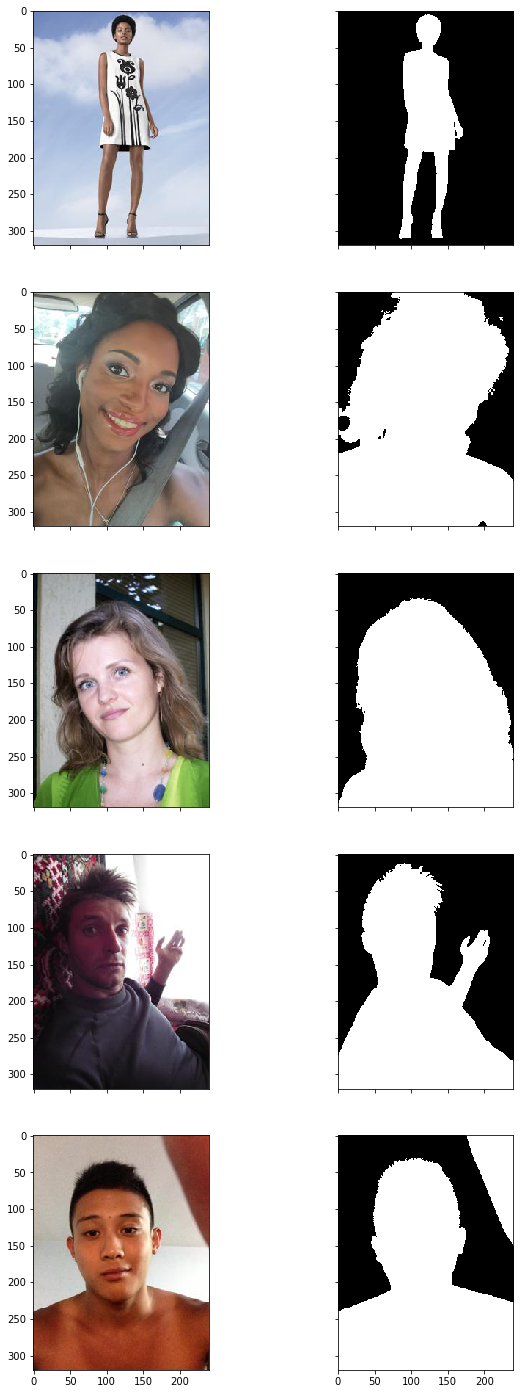

In [8]:

n_rows = 5
n_cols = 2

fig,axes = plt.subplots(n_rows,n_cols, squeeze=True, sharex=True, sharey=True, figsize=(n_cols*5,n_rows*5))

for c in range(n_rows):
    select_fp = np.random.choice(train_images, size=1,)[0]
    select_mask = os.path.join(MASK_DIR, select_fp.split('/')[-1].replace('jpg', 'png'))
    img = Image.open(select_fp)
    axes[c,0].imshow(img)
    mask = Image.open(select_mask)
    axes[c,1].imshow(mask)

# plt.tight_layout(pad=1.0, h_pad=0.5)
plt.show()

##### Load and preprocess image

1. Load images and masks both for training and validation
2. Resize to selected input dimensions
2. Normalize to be between 0 and 1
3. Reshape to 4 dimensions:
    - batch size x height x width x rgb channels for images
    - batch size x height x width x 1 for masks
4. Shuffle train set

In [9]:
def process_image(filepath, resize_to=None):
    '''
    Load image, convert to black-and-white, resize when needed, normalize and return as an array
    '''
    img = Image.open(filepath)
#     img = img.convert('L')
    if resize_to:
        img = img.resize((resize_to))
    img = np.array(img)
    img = img / 255.
    return img

crop_types = [
#     'upper_left', 
#     'lower_right', 
#     'center',
             ]
def crop_image(img_array, mask_array, target_width, target_height, crop_type):
    '''
    Crops image to specfigied shapes
    '''
    assert crop_type in crop_types
    if crop_type == 'upper_left':
        img_array = img_array[:target_height, :target_width, ]
        mask_array = mask_array[:target_height, :target_width, ]
    elif crop_type == 'lower_right':
        img_array = img_array[-target_height:, -target_width:, ]
        mask_array = mask_array[-target_height:, -target_width:, ]
    elif crop_type == 'center':
        h,w = img_array.shape
        h_start = int((h - target_height) // 2)
        w_start = int((w - target_width) // 2)
        img_array = img_array[h_start : h_start + target_height, w_start : w_start + target_width, ]
        mask_array = mask_array[h_start : h_start + target_height, w_start : w_start + target_width, ]
    return img_array, mask_array


def load_images(images_path, target_shape, target=True):
    '''
    Loads images and creates a pair of input and output arrays
    '''
    # create list to store arrays and iterate over all filepaths
    image_arrays = []
    target_arrays = []
    for fp in tqdm(images_path):
        # first process with resize a real image
        image = process_image(fp, resize_to=target_shape)
        image_arrays.append(image)
        if target: # used for train and validation arrays
            # then process with resize mask image
            mask_fp = os.path.join(MASK_DIR, fp.split('/')[-1].replace('jpg', 'png'))
            mask = process_image(mask_fp, target_shape)
            target_arrays.append(mask)
            for crop_type in crop_types:
                ## now without resizing but with cropping
                ## cut both image and mask to increase training size
                image = process_image(fp, resize_to=None)
                mask = process_image(mask_fp, resize_to=None)
                cropped_img, cropped_mask = crop_image(image, mask, 240, 240, crop_type)
                image_arrays.append(cropped_img)
                target_arrays.append(cropped_mask)
    return np.array(image_arrays), np.array(target_arrays)

In [10]:
input_width,input_height = 224,224
input_channels = 3

train_arrays,train_targets = load_images(train_images, (input_width,input_height), target=True)
val_arrays,val_targets = load_images(val_images, (input_width,input_height), target=True)
submit_arrays,_ = load_images(submit_images, (input_width,input_height), target=False)

nTrain = train_arrays.shape[0]
nValid = N_VALID * (len(crop_types) + 1)
train_arrays = np.reshape(train_arrays, (nTrain,input_width,input_height,input_channels))
val_arrays = np.reshape(val_arrays, (nValid,input_width,input_height,input_channels))
submit_arrays = np.reshape(submit_arrays, (submit_arrays.shape[0],input_width,input_height,input_channels))
train_targets = np.reshape(train_targets, (nTrain,input_width,input_height,1))
val_targets = np.reshape(val_targets, (nValid,input_width,input_height,1))

train_arrays.shape, val_arrays.shape, train_targets.shape, val_targets.shape, submit_arrays.shape

100%|██████████| 2177/2177 [00:07<00:00, 307.55it/s]


((1391, 224, 224, 3),
 (100, 224, 224, 3),
 (1391, 224, 224, 1),
 (100, 224, 224, 1),
 (2177, 224, 224, 3))

In [11]:
# shuffle to separate similar images obtained from cropping
new_indices = np.random.permutation(range(nTrain))
train_arrays = train_arrays[new_indices]
train_targets = train_targets[new_indices]

##### Visualize transformed images and their masks

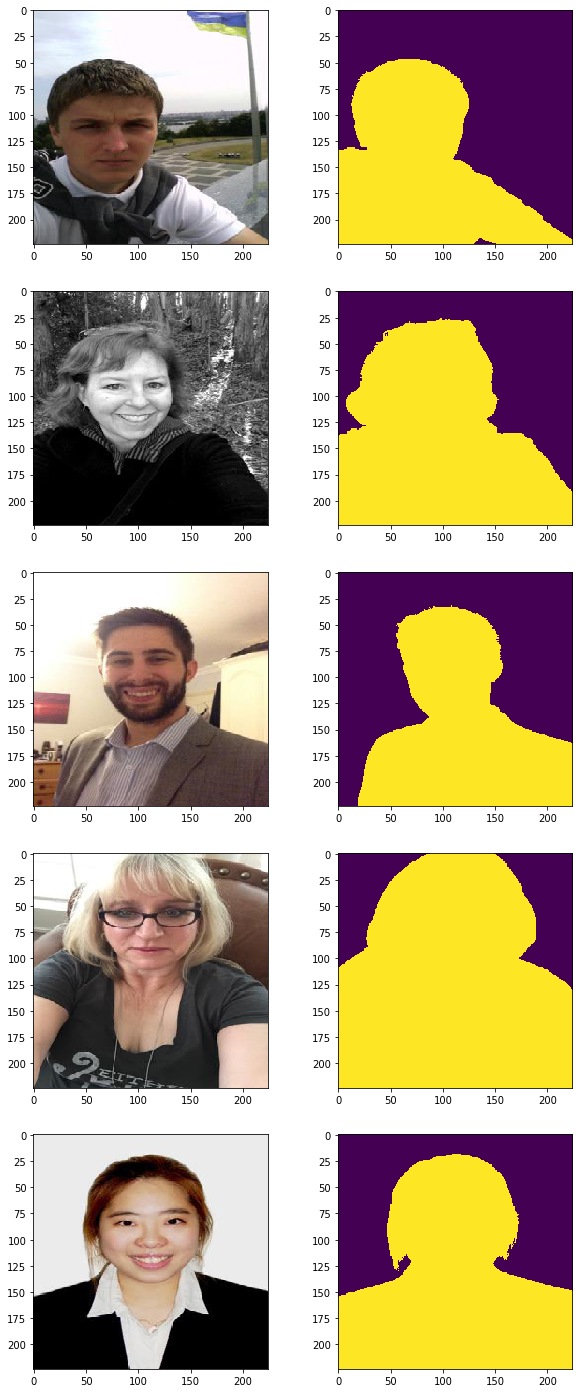

In [12]:
n_rows = 5
n_cols = 2

fig,axes = plt.subplots(n_rows,n_cols, squeeze=True, sharex=False, sharey=False, figsize=(n_cols*5,n_rows*5))

for c in range(n_rows):
    index = np.random.randint(0, train_arrays.shape[0], size=1)[0]
    axes[c,0].imshow(np.squeeze(train_arrays[index]))
    axes[c,1].imshow(np.squeeze(train_targets[index]))

# plt.tight_layout(pad=1.0, h_pad=0.5)
plt.show()

### Configure U-Net

In [13]:
from keras import models, layers
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import backend as K

Using TensorFlow backend.


##### Network architecture

In [14]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = layers.MaxPooling2D((2, 2)) (c1)
    p1 = layers.Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = layers.MaxPooling2D((2, 2)) (c2)
    p2 = layers.Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = layers.MaxPooling2D((2, 2)) (c3)
    p3 = layers.Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = layers.Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = layers.Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = layers.Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = layers.Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = layers.Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = layers.Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = models.Model(inputs=[input_img], outputs=[outputs])
    return model


def dice_coef(y_true, y_pred):
    threshold = 0.5
    smooth = 1e-8
    y_pred = K.cast(y_pred > threshold, 'float32')
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    true_sum, true_pred = K.sum(y_true), K.sum(y_pred)
    return (2 * intersection + smooth) / (true_sum + true_pred + smooth)

##### Set training params

In [28]:
BATCH_SIZE = 16
EPOCHS = 500

n_C_output = 1
start_filters = 64
dropout_rate = 0.1

starter_learning_rate = 0.005
lr_decay = 1
update_factor = 0.5
earlystop_wait = 10
reducelr_wait = 3

save_weights = 'base_model.h5'

##### Image augmentation

In [29]:
from keras.preprocessing.image import ImageDataGenerator

In [30]:
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.1,
)

In [31]:
seed = 100

train_datagen = datagen.flow(train_arrays, batch_size=BATCH_SIZE, shuffle=True, seed=seed)
mask_datagen = datagen.flow(train_targets, batch_size=BATCH_SIZE, shuffle=True, seed=seed)

train_generator = zip(train_datagen, mask_datagen)

##### Compile the model

In [32]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=earlystop_wait, min_delta=5e-4, verbose=1),
    ReduceLROnPlateau(factor=update_factor, patience=reducelr_wait, min_lr=1e-5, verbose=1, cooldown=3),
    ModelCheckpoint(save_weights, verbose=1, save_best_only=True, save_weights_only=True)
]

# opt = Adam(starter_learning_rate, decay=lr_decay, )
opt = Adagrad(lr=starter_learning_rate)

In [33]:
def compile_model(starting_channels, print_summary=True):
    input_img = layers.Input((input_width, input_height, input_channels), name='img')
    model = get_unet(input_img, n_filters=starting_channels, dropout=dropout_rate, batchnorm=True)

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[dice_coef])
    if print_summary:
        model.summary()
    return model

model = compile_model(start_filters)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 224, 224, 64) 1792        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 224, 224, 64) 256         conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 224, 224, 64) 0           batch_normalization_55[0][0]     
__________________________________________________________________________________________________
conv2d_59 

### Train and evaluate

##### Train the model

In [ ]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=int(len(train_arrays)//BATCH_SIZE), 
                              epochs=EPOCHS,
                              callbacks=callbacks,
                            validation_data=(val_arrays, val_targets))


Epoch 1/500
86/86 [==============================] - 48s 564ms/step - loss: 0.5671 - dice_coef: 0.7571 - val_loss: 0.5551 - val_dice_coef: 0.7777

Epoch 00001: val_loss improved from inf to 0.55507, saving model to base_model.h5
Epoch 2/500
86/86 [==============================] - 41s 475ms/step - loss: 0.4630 - dice_coef: 0.8208 - val_loss: 0.5557 - val_dice_coef: 0.7574

Epoch 00002: val_loss did not improve from 0.55507
Epoch 3/500
86/86 [==============================] - 39s 449ms/step - loss: 0.4015 - dice_coef: 0.8491 - val_loss: 0.3980 - val_dice_coef: 0.8482

Epoch 00003: val_loss improved from 0.55507 to 0.39796, saving model to base_model.h5
Epoch 4/500
86/86 [==============================] - 39s 450ms/step - loss: 0.3740 - dice_coef: 0.8596 - val_loss: 0.3766 - val_dice_coef: 0.8591

Epoch 00004: val_loss improved from 0.39796 to 0.37656, saving model to base_model.h5
Epoch 5/500
86/86 [==============================] - 39s 450ms/step - loss: 0.3504 - dice_coef: 0.8700 - va

##### Learning curve

In [ ]:
lr_value = np.array(history.history['lr'])
lr_change = np.where(lr_value[1:] != lr_value[:-1])

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(history.epoch, history.history['loss'], 'b--', label='train loss')
plt.plot(history.epoch, history.history['val_loss'], 'r--', label='val loss')
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history['dice_coef'], 'b--', label='train score')
plt.plot(history.epoch, history.history['val_dice_coef'], 'r--', label='val score')
for i in lr_change[0]:
    plt.axvline(x=i,color='green')
    plt.text(x=i,y=np.mean(history.history['val_dice_coef'])*0.95, s='lr %.5f' % lr_value[i+1], rotation=90)
plt.legend()
plt.show()

##### Load best model and evaluate

In [102]:
model = compile_model(32, print_summary=False)
model.load_weights('./adagrad_94_crop&augment.h5')

model.evaluate(val_arrays, val_targets)

100/100 [==============================] - 1s 13ms/step


[-0.9597809362411499, 0.9597809362411499]

##### ensemble best models

##### Predict valid and optimize threshold

In [22]:
from sklearn.metrics import accuracy_score

In [103]:
val_prediction = model.predict(val_arrays)

# val_prediction = ensemble_prediction.copy()

In [104]:
thresholds = range(0,100,5)
accuracies = []

for thresh in tqdm(thresholds):
    val_prediction_binary = np.uint8(val_prediction > thresh/100.)
    acc = accuracy_score(val_targets.reshape((-1)), val_prediction_binary.reshape((-1)))
    accuracies.append(acc)

100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


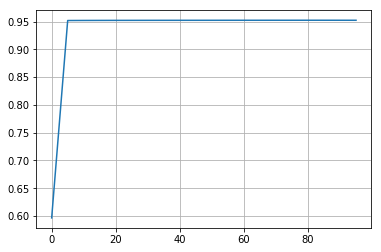

In [105]:
plt.plot(thresholds, accuracies);
plt.grid();

In [106]:
THRESHOLD = 0.5

##### visualize validation samples


|left |center |right |
----|---|----
|transformed image|model prediction|real mask|

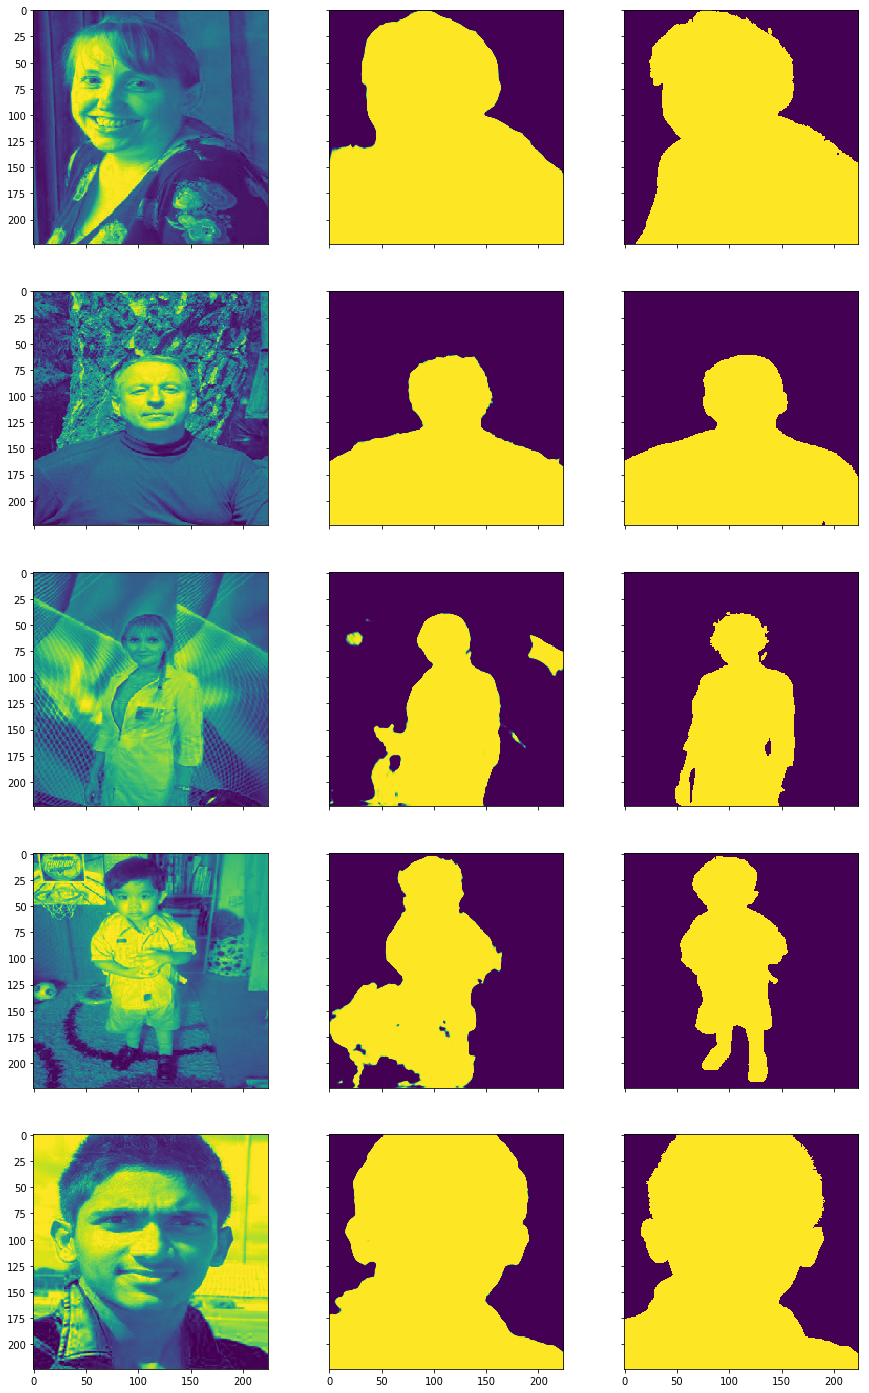

In [107]:
N_SHOW = 5
indices = np.random.choice(range(val_arrays.shape[0]), size=N_SHOW,)

n_cols = 3

fig,axes = plt.subplots(n_rows,n_cols, squeeze=True, sharex=True, sharey=True, figsize=(n_cols*5,n_rows*5))

for c,i in enumerate(indices):
    axes[c,0].imshow(val_arrays[i][:,:,0])
    axes[c,1].imshow(val_prediction[i][:,:,0])
    axes[c,2].imshow(val_targets[i][:,:,0])

# plt.tight_layout(pad=1.0, h_pad=0.5)
plt.show()

### Predict on test and submit

##### make predictions

In [109]:
submit_prediction = model.predict(submit_arrays)
# submit_prediction = ensemble_predict(best_models, submit_arrays)
submit_prediction = np.uint8(submit_prediction > THRESHOLD)

submit_prediction.shape

(2177, 224, 224, 1)

##### Visualize few predictions

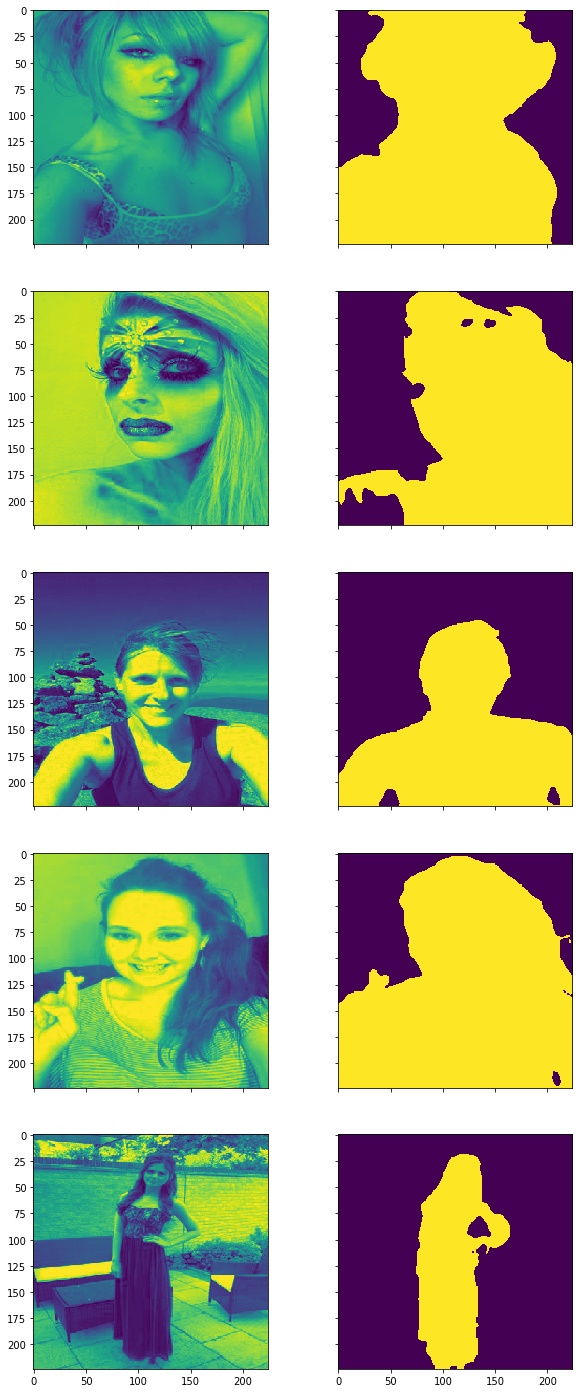

In [110]:
N_SHOW = 5
indices = np.random.choice(range(submit_arrays.shape[0]), size=N_SHOW,)

n_cols = 2

fig,axes = plt.subplots(n_rows,n_cols, squeeze=True, sharex=True, sharey=True, figsize=(n_cols*5,n_rows*5))

for c,i in enumerate(indices):
    axes[c,0].imshow(submit_arrays[i][:,:,0])
    axes[c,1].imshow(submit_prediction[i][:,:,0])

plt.show()

##### Convert to rle

In [111]:
from keras.preprocessing.image import img_to_array, array_to_img
from skimage.transform import resize

In [112]:
submit_rle = []

for ind,pred in tqdm(zip(submit_images,submit_prediction)):
    img = array_to_img(pred)
    resized = img.resize((240,320))
    resized = img_to_array(resized)
    encoded = rle_encode(resized)
    ind = ind.split('/')[-1].split('.')[0]
    submit_rle.append((ind, encoded))


2177it [00:02, 1004.16it/s]


##### convert to pandas and save

In [113]:
submit_rle = pd.DataFrame(submit_rle, columns=['image','rle_mask'])
submit_rle.sort_values('image', ascending=True, inplace=True)

submit_rle.head()

,image,rle_mask
397,1492,5614 4 5853 14 6093 14 6332 19 6569 28 6809 28...
672,1493,2485 11 2717 23 2957 23 3195 27 3434 29 3674 2...
800,1494,13811 14 14051 14 14269 38 14501 48 14735 54 1...
144,1495,12816 8 13053 12 13293 12 13531 16 13770 18 14...
719,1496,42 18 63 2 107 40 150 2 280 26 345 48 520 26 5...


In [114]:
submit_rle.to_csv('submission.csv', index=False)

Helpful links:
- [u-net in keras](https://www.depends-on-the-definition.com/unet-keras-segmenting-images/)
- [img segmentation overview](https://www.jeremyjordan.me/semantic-segmentation/#advanced_unet)
- [kaggle u-net](https://www.kaggle.com/piotrczapla/tensorflow-u-net-starter-lb-0-34)
- [practical u-net](https://tuatini.me/practical-image-segmentation-with-unet/)